In [1]:
from DiabetesModels import *

# Parameters for simulation
environment = read_env(ndim=2)

# Setup simulation from env dict
simulation = Simulation(environment._asdict())
# Get idea of paars to change
environment

# Turn notebook into script
# !jupyter nbconvert --to script config_template.ipynb


# Save as .py run file
if simulation.jupyter:
    !jupyter nbconvert --to script run_bayesian_2d.ipynb
    !mv run_bayesian_2d.py simulations/

[NbConvertApp] Converting notebook run_bayesian_2d.ipynb to script
[NbConvertApp] Writing 7663 bytes to run_bayesian_2d.py


In [2]:
#### 
#q=0 713
#q=0.025 660
#q=0.25 622
#q=0.5 797
#q=0.75 14
#q=0.975 535
#q=1 346 

In [3]:
print(environment)

env(path='debug/', maxPatient=1000, patientNr=0, path_to_simulations='simulations/', nMeals=200, ndim=2, loss_fun='CGP', jupyter=True, hypoglycemia=5, target=5, patient_filter=True, n_callibration=50)


In [4]:
# Change parameters of simulation here if you want to
# look above!
# simulation.par = xxx
if simulation.jupyter:
    simulation.patientNr = 622

# simulation.loss_fun = 'SQ'

# print environment for debugging purposes
simulation_tuple = namedtuple('debug_tuple', simulation.__dict__)
print(simulation_tuple(**simulation.__dict__))

debug_tuple(path='debug/', maxPatient=1000, patientNr=622, path_to_simulations='simulations/', nMeals=200, ndim=2, loss_fun='CGP', jupyter=True, hypoglycemia=5, target=5, patient_filter=True, n_callibration=50)


In [5]:
### Init patient
simulation.init_patient()

Basal rate found to be 6.7955379311432385 [mU/min] for patientNr 622


In [6]:
patient = simulation.patient

In [7]:
### Cell used for Bolus method

import GPy
import bayesoptlib as BO

bolus_range = np.linspace(0, 4, 5000)
meal_range = np.linspace(0, 100, 500)

var0 = 100
lscale = 1
kernel =  GPy.kern.Matern52(simulation.ndim,ARD=True,lengthscale=[lscale,1],variance=var0)
kernel.lengthscale.constrain_bounded(1e-5,1000)
kernel.variance.constrain_fixed()


### Make function that takes in Meal and returns bolus - this case Bayesian Optimization
def bolus_fun(Meal, simulation, return_CBO = False):
    patient = simulation.patient
    
    bolus_bounds = np.array([min(bolus_range), max(bolus_range)])

    # X_sample = np.vstack((patient.X_callibration, simulation.X_sample))
    # Y_sample = np.vstack((patient.Y_callibration, simulation.Y_sample))

    X_sample = simulation.X_sample
    Y_sample = simulation.Y_sample

    m = GPy.models.GPRegression(X_sample,Y_sample, kernel = kernel, noise_var=0)

    CBO = BO.contextual_bayesian_optimization(X_sample,Y_sample,Meal,bolus_bounds,
                                    kernel, m, X_grid = bolus_range)
                                    
    CBO.m.Gaussian_noise.variance.constrain_fixed()

    if len(X_sample) >= 20:
        CBO.m.optimize()
        
    CBO.query_next_UCB()
    Bolus = CBO.X_next[0][0]

    # have step for saving posterior, prior, acq function and such
    save_pred = False
    if save_pred and simulation.jupyter:
        try:
            patient.bayes_opt_posterior
        except: # First iteration
            # patient.bayes_opt_prior = []
            patient.bayes_opt_posterior = []
            patient.acq_fun = []
            patient.true_fun = []
    
        # patient.bayes_opt_prior.append(CBO.prior())

        # posterior
        mu, sigma = CBO.posterior()
        patient.bayes_opt_posterior.append(mu)
        patient.acq_fun.append(mu - 2 * sigma)

        # Obtain approximate true function
        patient.true_fun.append(patient.approx_loss(bolus_range, Meal.squeeze()))
        # Return CBO or Bolus?

    patient.CBO = CBO

    return Bolus

reconstraining parameters Mat52.lengthscale


In [8]:
### Do simulation
simulation.simulate(simulation.simulate_meals, bolus_fun = bolus_fun)

Simulating for PatientNr: 622: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]

Saving files for 622:


In [9]:
simulation.patient.CBO.m

In [10]:
simulation.patient.CBO.m.Mat52.lengthscale

GP_regression.Mat52.lengthscale:
Param([ 0.61086372, 17.16255136])

No handles with labels found to put in legend.


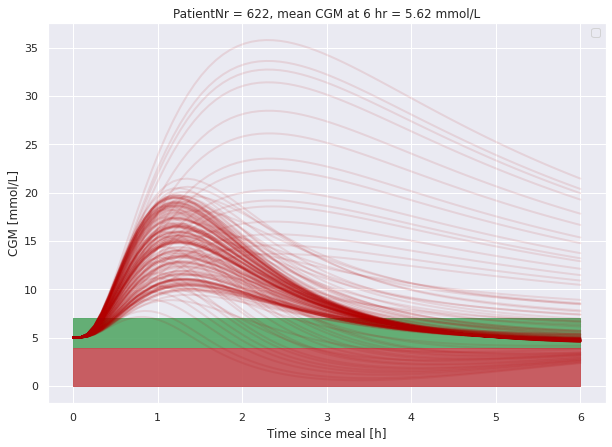

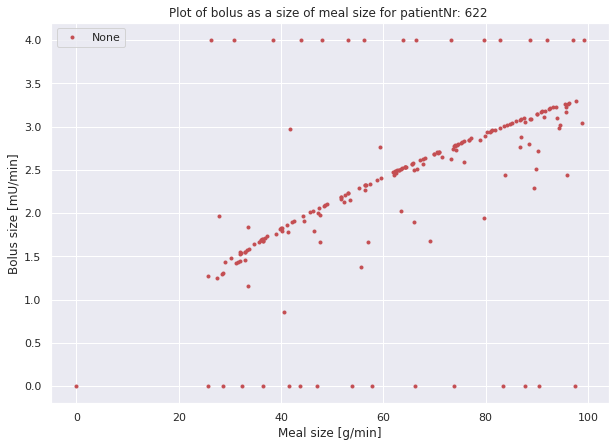

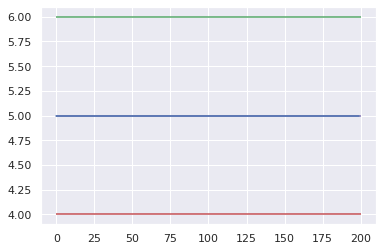

5.0 62.076388888888886 4.722222222222221


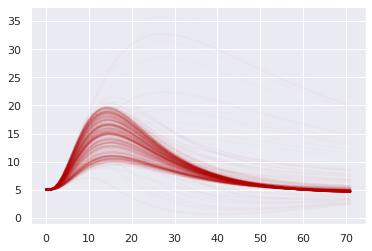

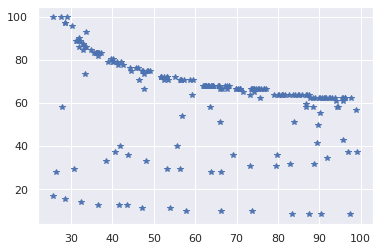

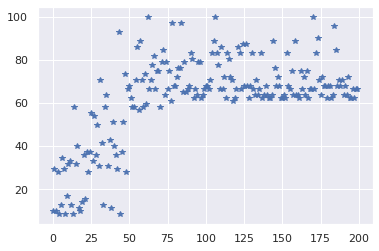

No handles with labels found to put in legend.


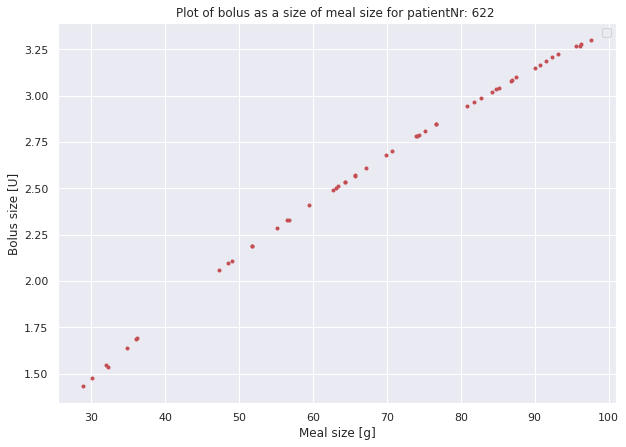

In [11]:
if simulation.jupyter:
    # simulation.patient.set_u_opt()
    simulation.plot_CGM()
    simulation.make_u_opt_plot()

    plt.figure()
    plt.plot(simulation.nBG0)
    plt.hlines(6,0,200,'g')
    plt.hlines(5,0,200,'m')
    plt.hlines(4,0,200,'r')
    plt.show()

    print(simulation.nBG0.mean(),simulation.nTIR.mean(), simulation.nTBR.mean())

    plt.figure()
    for i in range(200):
        plt.plot(simulation.nCGM[i,:],color=(0.7,0.0,0.0),linewidth=2,label='CGM', alpha = 0.1 * i/200)
    plt.show()
    
    plt.figure()
    plt.plot(simulation.nMeal,simulation.nTIR, '*', alpha = 0.95)
    plt.show()

    plt.figure()
    plt.plot(simulation.nTIR, '*', alpha = 0.95)
    plt.show()

    plt.figure(figsize=(10,7))
    #plt.plot(simulation.patient.u_opt_meal_range, simulation.patient.u_opt, '-*', label = 'Numerical interpolation (2D)', alpha = 0.5)
    # plt.plot(self.patient.u_opt_meal_range, self.patient.u_opt_meal_range * 20, '-g', label = '2')
    #plt.plot(simulation.patient.u_opt_meal_range, simulation.patient.u_opt_meal_range/simulation.patient.ICR, '-g', label = 'KN')
    plt.plot(simulation.X_sample[-50:,1], simulation.X_sample[-50:,0], 'r.')
    plt.xlabel('Meal size [g]')
    plt.ylabel('Bolus size [U]')
    plt.title(f'Plot of bolus as a size of meal size for patientNr: {simulation.patient.patientNr} ')
    plt.legend()
    plt.show()
    

In [12]:
def plot_process_i(i):
    patient = simulation.patient

    meal = simulation.nMeal[i]

    posterior = patient.bayes_opt_posterior[i]
    # prior = patient.bayes_opt_prior[i]
    true_fun = patient.true_fun[i]
    acq_fun = patient.acq_fun[i]


    plt.figure(figsize=(10,7))
    plt.title(f'Plot for patient {simulation.patient.patientNr} iteration {i} with meal = {meal:.2f} g/min')
    plt.plot(bolus_range, posterior, '-*', label = 'posterior')
    # plt.plot(bolus_range, prior, '-', label = 'prior')
    plt.plot(bolus_range, acq_fun, '-', label = 'LCB - acq fun')
    plt.plot(bolus_range, true_fun, '--', label = 'true_fun')
    plt.xlabel('Bolus [mU/min]')
    plt.ylabel('Value')

    # Let's plot KN estimates
    plt.vlines(meal/patient.ICR, min(true_fun), max(true_fun), 'r',  label = 'KN formula')
    plt.vlines((meal+5)/patient.ICR, min(true_fun), max(true_fun), 'g',  label = 'KN formula (+5g meal)')
    plt.vlines((meal-5)/patient.ICR, min(true_fun), max(true_fun), 'b',  label = 'KN formula (-5g meal)')


    # print((posterior - prior).sum())
    print((posterior - acq_fun).sum())

    #plt.xlim(min(patient.u_opt) - 50,max(patient.u_opt) + 500)
    #plt.xlim((meal-5)/patient.ICR,(meal+5)/patient.ICR)
    plt.ylim(50,3000)
    #plt.xlim(0,500)
    plt.legend()
    plt.savefig('prior_plot0.pdf', dpi = 150, bbox_inches='tight')
    plt.show()


In [13]:
simulation.X_sample

array([[ 0.        ,  0.        ],
       [ 0.        , 66.16101279],
       [ 4.        , 56.27665035],
       [ 0.        , 57.69961766],
       [ 2.48689738, 66.30984269],
       [ 3.55271054, 97.52723793],
       [ 1.57871574, 41.64948783],
       [ 1.58591718, 91.96451136],
       [ 3.29345869, 30.7231217 ],
       [ 0.        , 90.50720521],
       [ 2.31326265, 25.77806154],
       [ 4.        , 82.84904825],
       [ 0.77775555, 38.52022667],
       [ 4.        , 36.56221318],
       [ 2.9309862 , 83.32768079],
       [ 3.26305261, 63.54575078],
       [ 2.29805961, 88.6613273 ],
       [ 2.64932987, 41.74683094],
       [ 2.08681736, 47.0998752 ],
       [ 1.6035207 , 73.77806813],
       [ 0.        , 32.31502013],
       [ 0.9889978 , 69.10981008],
       [ 1.24424885, 28.65436606],
       [ 3.57191438, 40.6345403 ],
       [ 2.01480296, 63.79734129],
       [ 2.79175835, 97.00129775],
       [ 3.28625725, 90.25931025],
       [ 1.20344069, 48.09512145],
       [ 2.89337868,

-0.46658698600685966
1499999.6111112


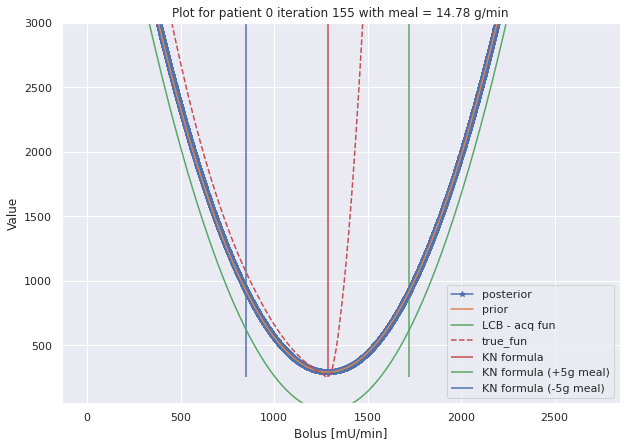

In [35]:
if simulation.jupyter:
    plot_process_i(155)